In [1]:
import torch
import datetime
import math
import matplotlib.pyplot as plt
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
from torchvision import datasets
import os
size = 1000

def generate_pair_sets():
    data_dir = os.environ.get('PYTORCH_DATA_DIR')
    if data_dir is None:
        data_dir = './data'

    train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    train_features = train_set.train_data.view(-1, 1, 28, 28).float()
    train_target = train_set.train_labels
    train_features = torch.functional.F.avg_pool2d(train_features, kernel_size = 2)

    test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)
    test_features = test_set.test_data.view(-1, 1, 28, 28).float()
    test_target = test_set.test_labels
    test_features = torch.functional.F.avg_pool2d(test_features, kernel_size = 2)

    return train_features, train_target, test_features, test_target

In [3]:
size = 1000
train_features, train_target, test_features, test_target = generate_pair_sets()

C:\Users\antho\Anaconda3\envs\venv_torch\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\antho\Anaconda3\envs\venv_torch\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\antho\Anaconda3\envs\venv_torch\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\antho\Anaconda3\envs\venv_torch\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
print(train_features.shape, train_target.shape)
print(test_features.shape, test_target.shape)

torch.Size([60000, 1, 14, 14]) torch.Size([60000])
torch.Size([10000, 1, 14, 14]) torch.Size([10000])


In [5]:
train_size = 1000
train_perm = torch.randperm(train_features.size(0))
idx = train_perm[:train_size]
train_features = train_features[idx].reshape([1000, 196])
train_target = train_target[idx]

test_features = test_features.reshape([test_features.size(0), 196])

In [6]:
def normalize(tensor):
    mean, std = tensor.mean(), tensor.std()
    return tensor.sub_(mean).div_(std)

normalize(train_features)
normalize(test_features)
print(train_features.shape, train_target.shape)
print(test_features.shape, test_target.shape)

torch.Size([1000, 196]) torch.Size([1000])
torch.Size([10000, 196]) torch.Size([10000])


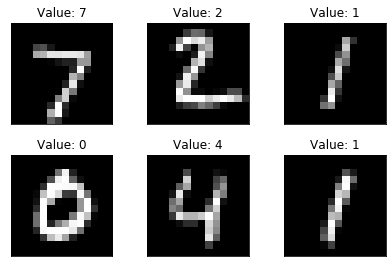

In [7]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(test_features[i].reshape([14, 14]), cmap='gray', interpolation='none')
    plt.title("Value: {}".format(test_target[i]))  
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])

# Pytorch model

In [8]:
# device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, dropout_p):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.ReLU = nn.ReLU() 
        self.softmax = nn.Softmax(dim=1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc3 = nn.Linear(hidden_size, num_class) 
        self.dropout = nn.Dropout(dropout_p) 
    
    def forward(self, x):
        x = self.dropout(self.ReLU(self.fc1(x)))
        x = self.ReLU(self.fc3(x))
        return x

In [9]:
# function to train each model
def train_model(model_, train_features_, train_target_, criterion_, optimizer_, num_epochs_, batch_size_, learning_rate_decay):
    # getting start time of train to get the train time at the end thanks to "end_time"
    start_time = datetime.datetime.now()
    # list to get train and test errors at each epoch
    train_error = []
    test_error = []
    # train function
    # Learning rate decay can be enabled or disabled than to an input in the function's parameters
    if learning_rate_decay:
        lambda_ = lambda epoch: 0.8 ** epoch
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_, lr_lambda=lambda_)
    for epoch in range(1, num_epochs_+1):
        # using technique of mini batch (size of the batch in the function's parameters)
        for i in range(int(len(train_features_)/batch_size_)):  
            # getting images and labels in right format
            images = train_features_.narrow(0,i*batch_size_,batch_size_)
            labels = train_target_.narrow(0,i*batch_size_,batch_size_)

            # Forward pass
            outputs = model_(images)
            loss = criterion_(outputs, labels)

            # Backward and optimize
            optimizer_.zero_grad()
            loss.backward()
            optimizer_.step()

        if learning_rate_decay:
            scheduler.step()
        # getting train error at each epoch
        train_error.append(test_accuracy(model_, train_features_, train_target_))
        test_error.append(test_accuracy(model_, test_features, test_target))
    # getting end time and training time
    end_time = datetime.datetime.now()
    training_time = end_time - start_time
    print(test_features.shape)
    print ('Loss: {:.4f} on epoch: 1, train error: {:.5f}%, test error: {:.5f}%'.format(loss.item(),epoch,train_error[0],test_error[0]))
    print ('Loss: {:.4f} on epoch: {}, train error: {:.5f}%, test error: {:.5f}%'.format(loss.item(),epoch,train_error[-1],test_error[-1]))
    return train_error, test_error, training_time

In [10]:
def test_accuracy(model_, my_test_features_, my_test_target_):
    outputs = model_(my_test_features_)
    _, predictions = torch.max(outputs.data, 1)
    count_errors = (predictions.long() != my_test_target_.long()).sum().item()
    return count_errors / my_test_features_.size(0) * 100

In [20]:
# number of epoch
num_epochs = 100
# batch size to compute mini-batch
batch_size = 10
# number of pixels in the image 
input_size = 196
# number of possible digit: 0 to 9 
num_class = 10
# small step to find a minima
learning_rate = 0.01
# hidden size
hidden_size = 128
# p dropout
p_dropout = 0.1
# learning rate decay
LRD = False

model = NeuralNet(input_size, hidden_size, num_class, p_dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
train_error, test_error, train_time = train_model(model, train_features, train_target, criterion, optimizer, num_epochs, batch_size, LRD)

torch.Size([10000, 196])
Loss: 0.3646 on epoch: 1, train error: 100.00000%, test error: 43.70000%
Loss: 0.3646 on epoch: 100, train error: 0.20000%, test error: 10.86000%


# Homemade framework

In [21]:
from homemade_framework import framework as NN

In [23]:
train_features_np, train_target_np = train_features.numpy(), train_target.numpy()
test_features_np, test_target_np = test_features.numpy(), test_target.numpy()

nb_epochs = 100
batch_size = 10

# Build the model
Model = NN.Sequential([NN.Linear(196,128), NN.LeakyReLU(), NN.Linear(128,10), NN.LeakyReLU()], NN.LossMSE())
# Set the learning rate
Model.set_Lr(0.01)

# Print model's parameters
Model.print(print_color=False)

# Convert train_target to one hot encoding
train_target_one_hot = NN.convert_to_one_hot_labels(train_features, train_target)

NN.print_current_results(0, Model, train_features_np, train_target_np, test_features_np, test_target_np, 0, prefix = "Before training: ")
test_results = []
for epochs in range(0, nb_epochs):
    loss_sum = 0
    test_results.append(NN.get_inferences(Model, test_features_np))
    for b in range(train_features.shape[0] // batch_size):
        output = Model.forward(train_features_np[list(range(b * batch_size, (b+1) * batch_size))])
        loss = Model.backward(train_target_one_hot[list(range(b * batch_size, (b+1) * batch_size))], output)
        loss_sum = loss_sum + loss.item()
    if epochs % 30 == 0:
        NN.print_current_results(epochs + 1, Model, train_features_np, train_target_np, test_features_np, test_target_np, loss_sum)
    
        
NN.print_current_results(epochs, Model, train_features_np, train_target_np, test_features_np, test_target_np, loss_sum, prefix = "After training: ")

Model description: 
	Linear layer shape: [196, 128]
	LeakyReLU activation
	Linear layer shape: [128, 10]
	LeakyReLU activation
	MSE
Before training: Epoch: 0, Train Error: 93.6000%, Test Error: 93.4800%, Loss  0.0000
Epoch: 1, Train Error: 90.7000%, Test Error: 88.9200%, Loss  1914.6347
Epoch: 31, Train Error: 1.5000%, Test Error: 10.8800%, Loss  24.3979
Epoch: 61, Train Error: 1.4000%, Test Error: 11.6600%, Loss  17.1543
Epoch: 91, Train Error: 1.0000%, Test Error: 11.7300%, Loss  15.6729
After training: Epoch: 99, Train Error: 0.9000%, Test Error: 11.5100%, Loss  13.8685
